# OCT simulations with Python

This notebook describes basic OCT signal processing steps for flow sensing

_J. Kalkman, Fourier-Domain Optical Coherence Tomography Signal Analysis and Numerical Modeling, International Journal of Optics 2017_

In [78]:
# basic functions
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#import scipy.interpolate
import scipy as sp


### Basic Fourier-domain OCT simulation for sensing application in a flow channel

We consider a Fourier domain OCT system. The signal is acquired in the $k$-domain and Fourier transformed to the $z$-domain. 

In [18]:
# OCT parameters
lambdac=950         # center wavelength [nm]
dlambda=150         # bandwidth [nm]
P0=1                # input power [mW]
tau=1e-6            # integration time [s]
N=1024              # number of pixels
alpha=0.5           # intensity splitting ratio

kc=2*np.pi/(lambdac*1e-9)
dk=1e9*dlambda*2*np.pi/lambdac**2             # FWHM_k
sigmak = dk/(2*np.sqrt(2*np.log(2))) 
kmin=kc-2*dk                        # 2*dk is necessary to avoid problems in the z-domain
kmax=kc+2*dk

k=np.linspace(kmin,kmax,N)
deltak=k[1]-k[0]
n0=np.linspace(0, N-1, N)       # pixel axis
z=np.linspace(-0.5*np.pi/deltak, 0.5*np.pi/deltak -(2*np.pi/(kmax-kmin)), N)
deltaz=z[2]-z[1]

0.00038318645833335845
-0.00038469062500002513


In [79]:
B1water=0.75831
C1water=0.01007
B2water=0.08495
C2water=8.91377
wavelength=1e6*2*np.pi/k

npow2=1+B1water*wavelength**2/(wavelength**2 - C1water) +B2water*wavelength**2/(wavelength**2 - C2water)
nk=np.sqrt(npow2)


We consider the sample consisting of two interfaces with a transparent medium with phase index $n(k)$ in between. The first interface is at a depth $z_1$, the second interface is at a depth $z_1+L$. The phase of the first reflector is $\phi_1= 2 k z_1$. The phase of the second reflector is $\phi_2 = 2 k (z_1+n(k)L)$. So the phase difference is $\Delta \phi = \phi_2 - \phi_1 = 2 k n(k) L$. Now we take the derivative of the phase difference to $k$, i.e.,

$$
    \frac{d}{dk} \Delta \phi = 2 k L \frac{dn(k)}{dk}  + 2 n(k) L \, .
$$

Rearranging terms we find that

$$
    \frac{1}{2L} \frac{d}{dk} \Delta \phi = n(k) + k \frac{dn(k)}{dk} = n_g \, .
$$
Hence, we can obtain the group index $n_g$ from this. Next we simulate the OCT signal for this situation and perform the above stated analysis.


Text(0, 0.5, 'OCT amplitude (arb. units)')

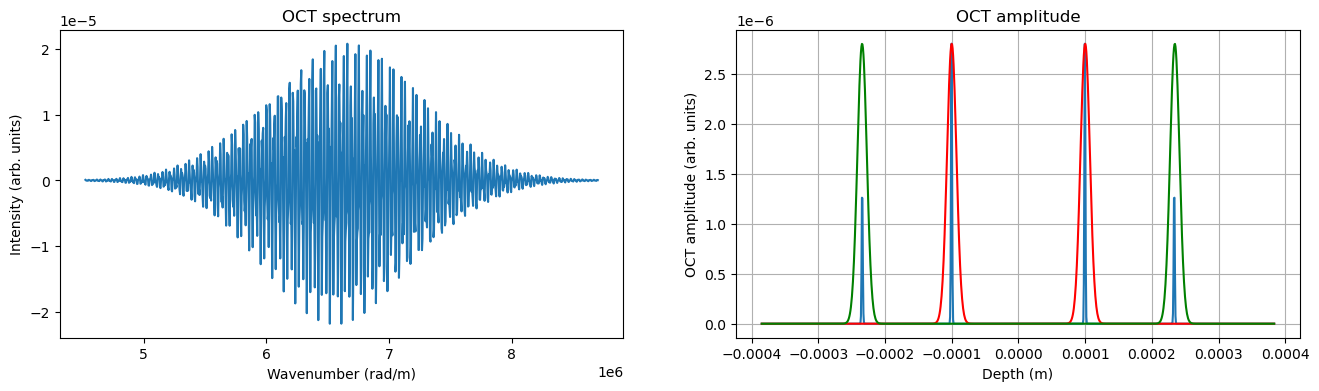

In [37]:

Sks=(P0*1e-3)/(np.sqrt(2*np.pi*sigmak**2))*np.exp(-(k-kc)**2/(2*sigmak**2))

zmir=100e-6
L=100e-6
r_1=1
r_2=0.5

Ukref=np.sqrt(alpha*(1-alpha))*np.sqrt(Sks)
Uksam=np.sqrt(alpha*(1-alpha))*np.sqrt(Sks)*(r_1*np.exp(1j*2*k*zmir) + r_2*np.exp(1j*2*k*(zmir+nk*L)))

Ikint=np.real(Uksam+Ukref*np.conj(Uksam+Ukref))-np.real(Ukref*np.conj(Ukref))-np.real(Uksam*np.conj(Uksam))

plt.figure(figsize=[16,4])
plt.subplot(121)
plt.plot(k, Ikint)
plt.title('OCT spectrum')
plt.xlabel('Wavenumber (rad/m)')
plt.ylabel('Intensity (arb. units)')

iz=np.fft.fftshift(np.fft.ifft(Ikint))

sigmaz=10e-6
filter1=np.max(np.abs(iz))*(np.exp(-(z-zmir)**2/sigmaz**2) + np.exp(-(z+zmir)**2/sigmaz**2))

# estimated peak position
ng=np.sqrt(npow2[N//2]) + kc * (np.sqrt(npow2[-1])-np.sqrt(npow2[0]))/(kmax-kmin)
zmir2=zmir+ng*L
filter2=np.max(np.abs(iz))*(np.exp(-(z-zmir2)**2/sigmaz**2) + np.exp(-(z+zmir2)**2/sigmaz**2))


plt.subplot(122)
plt.plot(z, np.abs(iz)), plt.grid()
plt.plot(z, filter1, '-r')
plt.plot(z, filter2, '-g')

plt.title('OCT amplitude')
plt.xlabel('Depth (m)')
plt.ylabel('OCT amplitude (arb. units)')



(Text(0.5, 0, 'Wavenumber (rad/m)'), Text(0, 0.5, 'Refractive index (-)'))

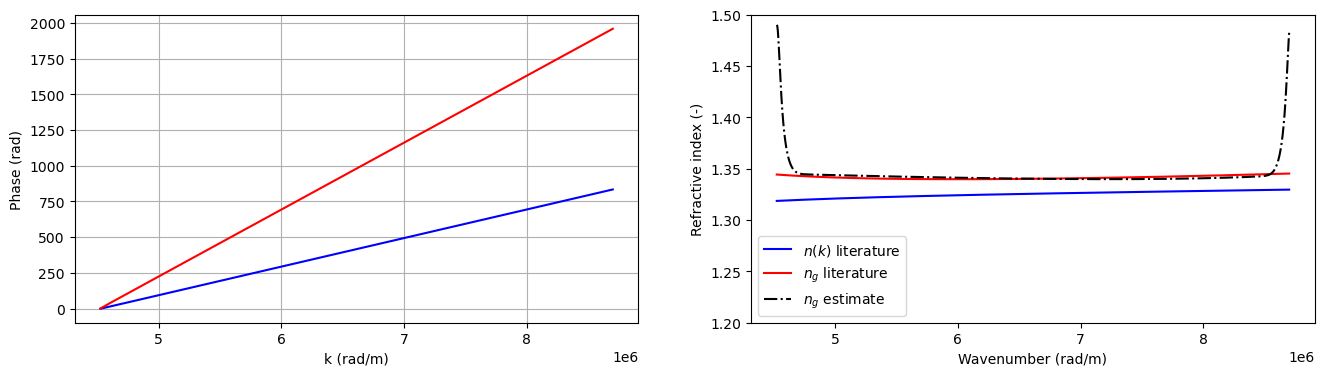

In [87]:
signalmir1=sp.signal.hilbert(np.real(np.fft.ifft(np.fft.fftshift(filter1*iz))))
signalmir2=sp.signal.hilbert(np.real(np.fft.ifft(np.fft.fftshift(filter2*iz))))

phase1=np.unwrap(np.angle(signalmir1))
phase2=np.unwrap(np.angle(signalmir2))

plt.figure(figsize=[16,4])
plt.subplot(121)
plt.plot(k, phase1, '-b')
plt.plot(k, phase2, '-r')
plt.grid(), plt.ylabel('Phase (rad)'), plt.xlabel('k (rad/m)')

ngest=(1/2/L)*(np.diff((phase2-phase1), n=1, append=1.325))/(k[1]-k[0])

plt.subplot(122)
ng = nk + k* (np.diff(nk, n=1, append=1.325))/(k[1]-k[0])

plt.plot(k[:-1], nk[:-1], '-b', label='$n(k)$ literature')
plt.plot(k[:-1], ng[:-1], '-r', label='$n_g$ literature')
plt.plot(k[:-1], ngest[:-1], '-.k', label='$n_g$ estimate')
plt.ylim([1.2, 1.5]), plt.legend()
plt.xlabel('Wavenumber (rad/m)'), plt.ylabel('Refractive index (-)')
